In [5]:
#@title imports 
import argparse
import gc
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Reshape, Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dense, BatchNormalization, ReLU, Add, LeakyReLU
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

from keras import Model

from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras import backend as K

ImportError: No module named 'keras'

In [2]:
#@title def make_generator

def make_generator():
  in_ = Input(shape=(256, 256, 3))
  conv1 = Conv2D(64, 7, padding="same")(in_)
  norm1 = BatchNormalization(epsilon=1e-9)(conv1)
  relu1 = ReLU()(norm1)

  # Down-convolution
  conv2 = Conv2D(128, 3, padding="same", strides=(2, 2))(relu1)
  conv3 = Conv2D(128, 3, padding="same")(conv2)
  norm2 = BatchNormalization(epsilon=1e-9)(conv3)
  relu2 = ReLU()(norm2)

  conv4 = Conv2D(256, 3, padding="same", strides=(2, 2))(relu2)
  conv5 = Conv2D(256, 3, padding="same")(conv4)
  norm3 = BatchNormalization(epsilon=1e-9)(conv5)
  relu3 = ReLU()(norm3)

  # 8 residual blocks
  # block_1
  res_conv1_1 = Conv2D(256, 3, padding="same")(relu3)
  res_norm_1 = BatchNormalization(epsilon=1e-9)(res_conv1_1)
  res_relu_1 = ReLU()(res_norm_1)
  res_conv2_1 = Conv2D(256, 3, padding="same")(res_relu_1)
  res_norm2_1 = BatchNormalization(epsilon=1e-9)(res_conv2_1)
  res_add_1 = Add()([relu3, res_norm2_1])

  # block_2
  res_conv1_2 = Conv2D(256, 3, padding="same")(res_add_1)
  res_norm_2 = BatchNormalization(epsilon=1e-9)(res_conv1_2)
  res_relu_2 = ReLU()(res_norm_2)
  res_conv2_2 = Conv2D(256, 3, padding="same")(res_relu_2)
  res_norm2_2 = BatchNormalization(epsilon=1e-9)(res_conv2_2)
  res_add_2 = Add()([relu3, res_norm2_2])

  # block_3
  res_conv1_3 = Conv2D(256, 3, padding="same")(res_add_2)
  res_norm_3 = BatchNormalization(epsilon=1e-9)(res_conv1_3)
  res_relu_3 = ReLU()(res_norm_3)
  res_conv2_3 = Conv2D(256, 3, padding="same")(res_relu_3)
  res_norm2_3 = BatchNormalization(epsilon=1e-9)(res_conv2_3)
  res_add_3 = Add()([relu3, res_norm2_3])

  # block_4
  res_conv1_4 = Conv2D(256, 3, padding="same")(res_add_3)
  res_norm_4 = BatchNormalization(epsilon=1e-9)(res_conv1_4)
  res_relu_4 = ReLU()(res_norm_4)
  res_conv2_4 = Conv2D(256, 3, padding="same")(res_relu_4)
  res_norm2_4 = BatchNormalization(epsilon=1e-9)(res_conv2_4)
  res_add_4 = Add()([relu3, res_norm2_4])

  # block_5
  res_conv1_5 = Conv2D(256, 3, padding="same")(res_add_4)
  res_norm_5 = BatchNormalization(epsilon=1e-9)(res_conv1_5)
  res_relu_5 = ReLU()(res_norm_5)
  res_conv2_5 = Conv2D(256, 3, padding="same")(res_relu_5)
  res_norm2_5 = BatchNormalization(epsilon=1e-9)(res_conv2_5)
  res_add_5 = Add()([relu3, res_norm2_5])

  # block_6
  res_conv1_6 = Conv2D(256, 3, padding="same")(res_add_5)
  res_norm_6 = BatchNormalization(epsilon=1e-9)(res_conv1_6)
  res_relu_6 = ReLU()(res_norm_6)
  res_conv2_6 = Conv2D(256, 3, padding="same")(res_relu_6)
  res_norm2_6 = BatchNormalization(epsilon=1e-9)(res_conv2_6)
  res_add_6 = Add()([relu3, res_norm2_6])

  # block_7
  res_conv1_7 = Conv2D(256, 3, padding="same")(res_add_6)
  res_norm_7 = BatchNormalization(epsilon=1e-9)(res_conv1_7)
  res_relu_7 = ReLU()(res_norm_7)
  res_conv2_7 = Conv2D(256, 3, padding="same")(res_relu_7)
  res_norm2_7 = BatchNormalization(epsilon=1e-9)(res_conv2_7)
  res_add_7 = Add()([relu3, res_norm2_7])

  # block_8
  res_conv1_8 = Conv2D(256, 3, padding="same")(res_add_7)
  res_norm_8 = BatchNormalization(epsilon=1e-9)(res_conv1_8)
  res_relu_8 = ReLU()(res_norm_8)
  res_conv2_8 = Conv2D(256, 3, padding="same")(res_relu_8)
  res_norm2_8 = BatchNormalization(epsilon=1e-9)(res_conv2_8)
  res_add_8 = Add()([relu3, res_norm2_8])

  # Up-convolution
  upconv1 = Conv2DTranspose(128, 3, padding="same", strides=(2, 2))(res_add_8)
  upconv2 = Conv2D(128, 3, padding="same")(upconv1)
  upnorm1 = BatchNormalization(epsilon=1e-9)(upconv2)
  uprelu1 = ReLU()(upnorm1)

  upconv3 = Conv2DTranspose(64, 3, padding="same", strides=(2, 2))(uprelu1)
  upconv4 = Conv2D(64, 3, padding="same")(upconv3)
  upnorm2 = BatchNormalization(epsilon=1e-9)(upconv4)
  uprelu2 = ReLU()(upnorm2)

  out_ = Conv2D(3, 7, padding="same")(uprelu2)
  return Model(in_, out_)


In [3]:
#@title def make_discriminator

def make_discriminator():
  in_ = Input(shape=(256, 256, 3))
  conv1 = Conv2D(32, 3, padding="same")(in_)
  relu1 = LeakyReLU(alpha=0.2)(conv1)

  conv2 = Conv2D(64, 3, padding="same", strides=(2, 2))(relu1)
  relu2 = LeakyReLU(alpha=0.2)(conv2)
  conv3 = Conv2D(128, 3, padding="same")(relu2)
  norm1 = BatchNormalization(epsilon=1e-9)(conv3)
  relu3 = LeakyReLU(alpha=0.2)(norm1)

  conv4 = Conv2D(128, 3, padding="same", strides=(2, 2))(relu3)
  relu4 = LeakyReLU(alpha=0.2)(conv4)
  conv5 = Conv2D(256, 3, padding="same")(relu4)
  norm2 = BatchNormalization(epsilon=1e-9)(conv5)
  relu5 = LeakyReLU(alpha=0.2)(norm2)

  conv6 = Conv2D(256, 3, padding="same")(relu5)
  norm3 = BatchNormalization(epsilon=1e-9)(conv6)
  relu6 = LeakyReLU(alpha=0.2)(norm3)
  conv7 = Conv2D(1, 3, padding="same")(relu6)
  
  flat = Reshape((4096,))(conv7)
  
  out_ = Dense(1, activation='sigmoid')(flat)
  return Model(in_, out_)


In [4]:
#@title def make_vggModel; runs
def make_vggModel():
  vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
  return Model(vgg.input, vgg.get_layer('block4_conv4').output)

vgg = make_vggModel()

In [5]:
#@title def vggLoss
def vggLoss(y_pred, y_true):
  return K.sum(K.abs(vgg(y_pred) - vgg(y_true)))


In [6]:
#@title def getDataFromPath
def getDataFromPath(path, limit=4800):
  data = []
  for (_, _, fnames) in os.walk(path):
    limit = min(limit, len(fnames))
    for fname in fnames[:limit]:
      fpath = path + "/" + fname
      im = np.array(Image.open(fpath))
      data.append(im)
  return np.asarray(data)

In [7]:
#@title def getDataFromPathByBatch
def getDataFromPathByBatch(path, current, batch_size=128):
  for (_, _, fnames) in os.walk(path):
    limit = min(4800, len(fnames))
    if current >= limit:
      return None, None
    data = []
    for fname in fnames[current:current+batch_size]:
      fpath = path + "/" + fname
      im = np.array(Image.open(fpath))
      data.append(im)
    return current+batch_size, np.asarray(data)

In [8]:
#@title def getDataFromPathIndividual (resizes and crops to center 256x256)
def getDataFromPathIndividual(paths):
  data = []
  for path in paths:
    im = np.array(Image.open(path))
#     width = int(256/im.shape[0]*im.shape[1]) # calculate goal width, assuming width>height
#     im = cv2.resize(im, (width, 256)) # resize
#     crop_index = int(im.shape[1]/2 - 256/2) # crop index so width is 256
#     im = im[:, crop_index:crop_index+256] # crop
    data.append(im)
  return np.asarray(data)

In [9]:
#@title class CartoonGAN
class CartoonGAN():
    def __init__(self):
        self.g = make_generator()
        self.d = make_discriminator()
        #     in_ = Input(shape=(256, 256, 3))
        #     x = self.g(in_)
        #     out_ = self.d(x)
        #     self.gan = Model(in_, out_)
        self.adam = Adam(lr=1e-6, decay=1e-4)
        self.g.compile(loss=self.cartoonGANLoss, optimizer=self.adam)
        self.d.compile(loss=binary_crossentropy, optimizer=self.adam)
        #     self.gan.compile(loss=binary_crossentropy, optimizer=self.adam)

    def cartoonGANLoss(self, y_pred, y_true):
        eLoss = -K.log(1 - self.d(y_pred) + 1e-20) - K.log(1 - self.d(y_true) + 1e-20)
        vLoss = vggLoss(y_pred, y_true)
        omega = 10
        return eLoss + omega * vLoss
  
    def pretrainGenerator(self, datapath=None, batch_size=128, epochs=5):
        # goal of this step is to reconstruct image
        path = 'initializedGenerator.hdf5'

        if os.path.isfile(path):
            self.g.load_weights(path)
        elif os.path.isdir(datapath) is False:
            print("Pretraining data path is not provided. Did not pretrain.")
        else:
            for i in range(epochs):
                print("\nEpoch {}.".format(i))
                current = 0
                _, data = getDataFromPathByBatch(datapath, current, batch_size=batch_size)
                while data is not None:
                    if current % 800 == 0:
                        gc.collect()
                        print("{}...".format(current), end="")
                    self.g.train_on_batch(data, data)
                    current, data = getDataFromPathByBatch(datapath, current, batch_size=batch_size)
            self.g.save_weights(path)

    def pretrainGeneratorOnEdges(self, datapath=None, datapath2=None, batch_size=128, epochs=5):
        # goal of this step is to reconstruct image
        path0 = 'initializedGenerator.hdf5'
        path = 'initializedGenerator2.hdf5'

        if os.path.isfile(path):
            self.g.load_weights(path)
        elif os.path.isdir(datapath) is False:
            print("Pretraining data path is not provided. Did not pretrain.")
        else:
            self.g.load_weights(path0)
            for i in range(epochs):
                print("\nEpoch {}.".format(i))
                current = 0
                _, data = getDataFromPathByBatch(datapath, current, batch_size=batch_size)
                _, data2 = getDataFromPathByBatch(datapath2, current, batch_size=batch_size)
                while data is not None:
                    if current % 800 == 0:
                        gc.collect()
                        print("{}...".format(current), end="")
                    self.g.train_on_batch(data, data2)
                    _, data = getDataFromPathByBatch(datapath, current, batch_size=batch_size)
                    current, data2 = getDataFromPathByBatch(datapath2, current, batch_size=batch_size)
            self.g.save_weights(path)
            
    def pretrainDiscriminator(self, truepath=None, fakepath=None, fakepath2=None, batch_size=128, epochs=5):
        path = 'initializedDiscriminator.hdf5'

        if os.path.isfile(path):
            self.d.load_weights(path)
        elif os.path.isdir(truepath) is False:
            print("Pretraining data path is not provided. Did not pretrain.")
        else:
            anime_y_true = np.ones((batch_size,))
            fuzzy_y_true = np.zeros((batch_size,))
            photos_y_true = np.zeros((batch_size,))
            y_true = np.concatenate((anime_y_true, fuzzy_y_true))
            y_true = np.concatenate((y_true, photos_y_true))
            gc.collect()

            for i in range(epochs):
                print("\nEpoch {}.".format(i))
                current = 0
                _, data = getDataFromPathByBatch(truepath, current, batch_size=batch_size)
                _, data2 = getDataFromPathByBatch(fakepath, current, batch_size=batch_size)
                _, data3 = getDataFromPathByBatch(fakepath2, current, batch_size=batch_size)
                while data is not None:
                    new_data = np.concatenate((data, data2))
                    new_data = np.concatenate((new_data, data3))
                    if current % 800 == 0:
                        gc.collect()
                        print("{}...".format(current), end="")
                    self.d.train_on_batch(new_data, y_true)
                    _, data = getDataFromPathByBatch(truepath, current, batch_size=batch_size)
                    _, data2 = getDataFromPathByBatch(fakepath, current, batch_size=batch_size)
                    current, data3 = getDataFromPathByBatch(fakepath2, current, batch_size=batch_size)
            self.d.save_weights(path)

    def train(self, photos_path, anime_path, fuzzy_path, batch_size, epochs=100, test_image=None):
        path = 'checkpoints/'
        gan.g.load_weights('checkpoints/generator_0.hdf5')
        gan.d.load_weights('checkpoints/discriminator_0.hdf5')
        
        anime_y_true = np.ones((batch_size,))
        fuzzy_y_true = np.zeros((batch_size,))
        gen_anime_y_true = np.zeros((batch_size,))
        y_true = np.concatenate((anime_y_true, fuzzy_y_true))
        y_true = np.concatenate((y_true, gen_anime_y_true))

        for i in range(epochs):
            print("\nEpoch {}.".format(i))
            current = 0

            _, photos = getDataFromPathByBatch(photos_path, current, batch_size=batch_size)
            _, anime = getDataFromPathByBatch(anime_path, current, batch_size=batch_size)
            current, fuzzy = getDataFromPathByBatch(fuzzy_path, current, batch_size=batch_size)
            
            # train discriminator
            while photos is not None:  
                data = np.concatenate((anime, fuzzy))
                gen_anime = self.g.predict(photos)
                this_data = np.concatenate((data, gen_anime))
                self.d.fit(this_data, y_true, validation_split=0.1, batch_size=batch_size)

                # train generator
                train_output = photos
                self.g.fit(photos, train_output, validation_split=0.1, batch_size=batch_size)

                gc.collect()
                _, photos = getDataFromPathByBatch(photos_path, current, batch_size=batch_size)
                _, anime = getDataFromPathByBatch(anime_path, current, batch_size=batch_size)
                current, fuzzy = getDataFromPathByBatch(fuzzy_path, current, batch_size=batch_size)
            if test_image is not None:
                self.generate(test_image, 'epoch_' + str(i) + '.jpg')
            self.g.save_weights(path + 'generator_' + str(i) + ".hdf5")
            self.d.save_weights(path + 'discriminator_' + str(i) + ".hdf5")
  
    def generate(self, data, output_name=None):
        pred = self.g.predict(data)
        for i in range(pred.shape[0]):
            im_array = pred[i]
            im = Image.fromarray((im_array * 255 / np.max(im_array)).astype('uint8'))
        #       if output_name is not None:
        #         im.save('sample_out/' + output_name)
        #       else:
        #         im.save('sample_out/' + str(i) + '.jpg')

        return pred[0]
    

In [24]:
#@title get test data for training
testdata = getDataFromPathIndividual(['dataset/flickr_train256x256/2438616168.jpg'])
# testdata = getDataFromPathIndividual(['dataset/sailor_moon_train256x256/130.jpg'])


In [11]:
#@title create GAN and run initializer
gan = CartoonGAN()
gan.pretrainGenerator(datapath='dataset/flickr_train256x256', batch_size=16, epochs=5)
gan.pretrainGeneratorOnEdges(datapath='dataset/sailor_moon_fuzzy_train256x256', datapath2='dataset/sailor_moon_train256x256', batch_size=16, epochs=5)

In [12]:
gan.pretrainDiscriminator(truepath='dataset/sailor_moon_train256x256', fakepath='dataset/sailor_moon_fuzzy_train256x256', batch_size=32, epochs=5)

In [13]:
gan.d.predict(testdata)

array([[0.84444565]], dtype=float32)

In [14]:
#@title load training data photos
photospath = 'dataset/flickr_train256x256'
# photos = getDataFromPath('dataset/flickr_train256x256', limit=400)

In [15]:
#@title load training data anime
animepath = 'dataset/sailor_moon_train256x256'
# anime = getDataFromPath('dataset/sailor_moon_train256x256', limit=400)

In [16]:
#@title load training data fuzzy
fuzzypath = 'dataset/sailor_moon_fuzzy_train256x256'
# fuzzy = getDataFromPath('dataset/sailor_moon_fuzzy_train256x256', limit=400)

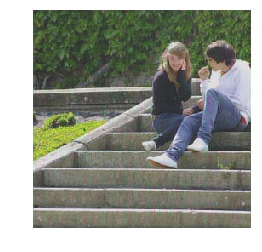

In [25]:
gan.g.load_weights('checkpoints/generator_0.hdf5')
im = gan.generate(testdata)
im = (im - np.min(im)) * 255 / (np.max(im) - np.min(im))
# im = im.reshape((1, 256, 256, 3))
# gan.d.predict(im)

im = Image.fromarray(im.astype('uint8'))
plt.axis('off')
plt.imshow(im)
# 

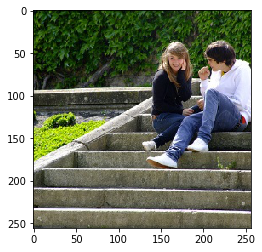

In [18]:
plt.imshow(testdata[0])

In [ ]:
#@title train GAN
gan.train(photospath, animepath, fuzzypath, 16, test_image=testdata)

In [ ]:
gc.collect()